# **1. Configuración del Ambiente**


---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sqlalchemy import create_engine, text

# **2. Obtención de datos (Motor DB)**


---

In [7]:
# Conectar a la base de datos
engine = create_engine('sqlite:///database.db')

# Crear una conexión y ejecutar la consulta SQL
with engine.connect() as connection:
    consulta_sql = text("""
        SELECT p.producto_id, p.producto, p.marca,
               SUM(i.cantidad) AS cantidad_vendida,
               SUM(i.cantidad * pr.precio) AS monto_total
        FROM productos p
        INNER JOIN items_pedidos i ON p.producto_id = i.producto_id
        INNER JOIN productos pr ON p.producto_id = pr.producto_id
        GROUP BY p.producto_id, p.producto, p.marca
        ORDER BY cantidad_vendida DESC
        LIMIT 5
    """)
    resultados = connection.execute(consulta_sql)

    # Guardar los resultados en un DataFrame
    df = pd.DataFrame(resultados, columns=['producto_id', 'producto', 'marca', 'cantidad_vendida', 'monto_total'])
    
    df["monto_total"] = (df["monto_total"]/1000).apply(lambda x: f'${x:.0f}K')


In [8]:
df.sample(5)

,producto_id,producto,marca,cantidad_vendida,monto_total
2,47405,Blusa Manga Estampa,Animale,536,$166K
0,32126,Saia Midi Cinto,Limone By Jade Seba,549,$115K
4,53941,Cropped Escritas Pb,Linda de Morrer,508,$142K
3,33976,Camisa Xadrez Azul,Hollister,511,$61K
1,13814,Vestido Nude Reta,Ellus,547,$301K


# **3. ¿Cual es el Top 5 productos más vendidos históricamente?**


---

In [9]:
images_path = ['blusa.png', 'blusa.png', 'blusa.png', 'blusa.png', 'blusa.png']

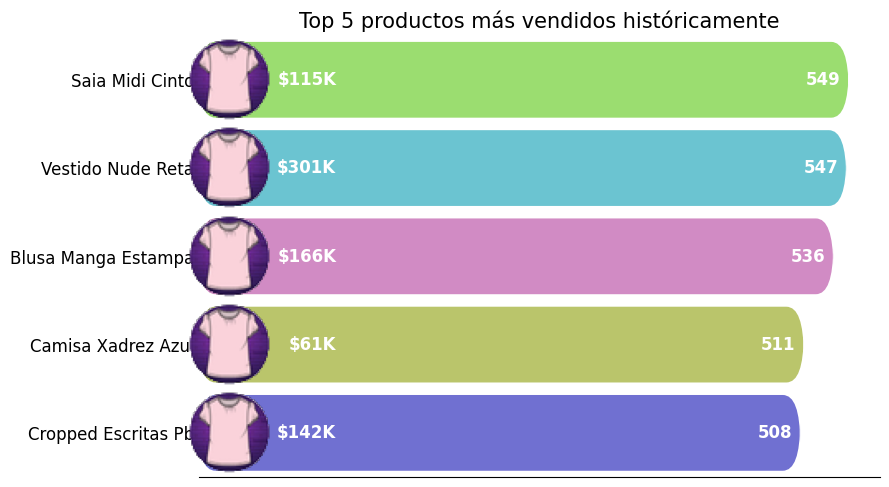

In [10]:
# Concatenar nombre y marca en una sola columna
#df['producto'] = df['producto'] +'  '+ '\n' + df['marca'] +'  '

# Crear la figura con el tamaño deseado
plt.figure(figsize=(9, 5))

# Crear el gráfico de barras horizontal
ax = sns.barplot(x=df.cantidad_vendida / 20, y=df.producto, orient='h', joinstyle='bevel')

# Definir colores pasteles para las barras
colores_pastel = ['#9BDD70', '#6BC4D1', '#D18BC4', '#BAC56B', '#7070D1']

new_patches = []
for i, patch, producto, cantidad_vendida, monto_total, image_path, color in zip(range(len(df)), ax.patches, df['producto'], df['cantidad_vendida'], df['monto_total'], images_path, colores_pastel):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle='round,pad=0.04,rounding_size=0.73',
                            ec="none", fc=color,
                            mutation_aspect=0.73)
    patch.remove()
    new_patches.append(p_bbox)

    # Añadir imagen dentro de la barra
    image = plt.imread(image_path)
    imagebox = OffsetImage(image, zoom=1.19)
    ab = AnnotationBbox(imagebox, xy=(1.3, patch.get_y() + patch.get_height() / 2),
                        xybox=(0, 0), xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle='-', color='none'),
                        bboxprops=dict(facecolor='none', edgecolor='none'))
    ax.add_artist(ab)

    # Añadir texto (cantidad_vendida) al lado izquierdo de la barra
    ax.annotate(f'{cantidad_vendida}', xy=(patch.get_width(), patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

    # Añadir texto (monto_total) al lado derecho de la barra
    ax.annotate(f'{monto_total}', xy=(6.1, patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

for patch in new_patches:
    ax.add_patch(patch)
    
sns.despine(left=True, bottom=True)
sns.despine(left=True)  # Eliminar los bordes izquierdos
plt.title('Top 5 productos más vendidos históricamente', fontsize=15)
plt.ylabel('')  # Eliminar el texto del eje y
plt.xlabel('')  # Eliminar el texto del eje x
plt.grid(False)  # Eliminar la cuadrícula
plt.xticks([])  # Eliminar las marcas del eje x
plt.yticks(fontsize=12)  # Ajustar el tamaño de la fuente en el eje y

ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()

# Eliminar la etiqueta del eje x 
ax.xaxis.label.set_visible(False)

# Mostrar el gráfico
plt.show()